In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import keras_tuner
from keras import layers, models
from sklearn.metrics import precision_recall_fscore_support as prf

from IPython import display #Used to play audio sample
import pyaudio              #Used for real time audio detection

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Importing Dataset

For the data, we have 8 folders, one for each label, containing 1000 audio files each.  
- We now get 100 batches, each of size 64 (one batch contains 64 audio files). 
- The audio files are also normalized to have a sequence length of 16000, since majority of the files contain this length.

In [2]:
#data_dir = 'data\mini_speech_commands'
data_dir = r'E:\Academics\UniPD\Courses\Semester_3\Human Data Analytics\Project\data\mini_speech_commands'

labels = np.array(os.listdir(data_dir))
labels = labels[(labels != 'README.md')]
print(f'Labels: {labels} \n')

for label in labels:
    direct = data_dir + f'\{label}'
    print(f'Audio Files in Folder {label}: {len(os.listdir(direct))}')

Labels: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes'] 

Audio Files in Folder down: 1000
Audio Files in Folder go: 1000
Audio Files in Folder left: 1000
Audio Files in Folder no: 1000
Audio Files in Folder right: 1000
Audio Files in Folder stop: 1000
Audio Files in Folder up: 1000
Audio Files in Folder yes: 1000


In [3]:
sample_rate = 16000
batch_size = 32
val_test_split = 0.3

train_data, val_data = tf.keras.utils.audio_dataset_from_directory(
                            directory=data_dir,
                            batch_size = batch_size,
                            validation_split=val_test_split,
                            seed = 0,
                            output_sequence_length=sample_rate,
                            subset='both')

Found 8000 files belonging to 8 classes.
Using 5600 files for training.
Using 2400 files for validation.


In [4]:
test_data = val_data.shard(num_shards = 2, index = 0)
val_data = val_data.shard(num_shards = 2, index = 1)

#### Shapes of the datasets

In [5]:
#Gets shapes of the data (excluding labels)
def get_shapes(data, return_shape = False):
    print(f'Number of Training Batches: {len(data)}')

    #Getting shape of single batch
    for batch_audio, batch_labels in data:
        break

    print(f'Shape of audio data in batch: {batch_audio.shape}')
    print(f'Shape of labels in batch: {batch_labels.shape}')

    if return_shape: return batch_audio.shape
    return None

In [6]:
get_shapes(train_data)

Number of Training Batches: 175
Shape of audio data in batch: (32, 16000, 1)
Shape of labels in batch: (32,)


In [7]:
get_shapes(val_data)

Number of Training Batches: 37
Shape of audio data in batch: (32, 16000, 1)
Shape of labels in batch: (32,)


In [8]:
get_shapes(test_data)

Number of Training Batches: 38
Shape of audio data in batch: (32, 16000, 1)
Shape of labels in batch: (32,)


#### Confirming equipartition of classes among batches

In [9]:
counts = {i: 0 for i in range(8)}

#Goes through each batch in train_data
for audio_batch, labels_batch in train_data:
    #Gets the counts of unique labels in each batch (64 samples, each corresponding to a label)
    unique_labels, count_labels = np.unique(np.array(labels_batch), return_counts = True)

    for pos in range(len(unique_labels)):
        counts[unique_labels[pos]] += count_labels[pos]

[Text(0.5, 0, '\n Labels'),
 Text(0, 0.5, 'Mean Frequency \n'),
 Text(0.5, 1.0, 'Average Label Occurrence per Batch \n')]

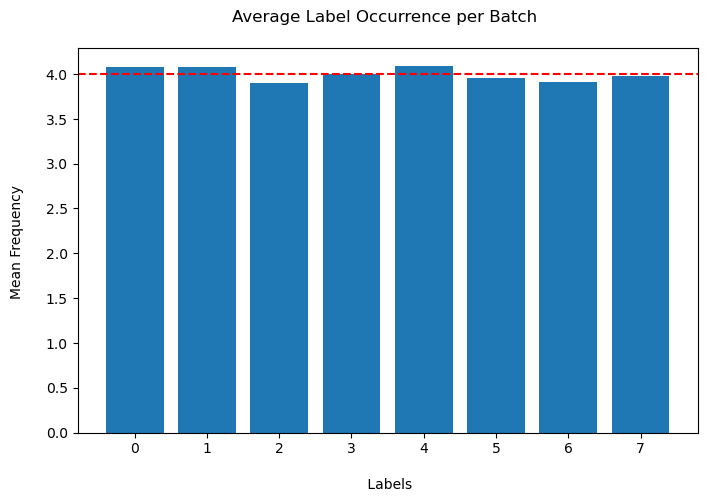

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))

n_batch = len(train_data)


ax.bar(counts.keys(), np.array(list(counts.values())) / n_batch)
ax.axhline(y = 4, color = 'red', linestyle = '--')
ax.set(xlabel = '\n Labels', 
        ylabel = 'Mean Frequency \n', 
        title = 'Average Label Occurrence per Batch \n')

## Preprocessing Data

#### Reducing Tensor Dimension

The dataset is shaped as (batches, samples, channels).  However, we only have one audio channel here. So, we need to take out the channel dimension.  However, the dataset object consists of both the (data, target).  Thus, we need to separate the data from the target, reduce its dimension and then return in the initial form as (data, target).  

We utilize the map method for doing this.

In [11]:
train_data._structure

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [12]:
def squeeze(audio_data, audio_labels):
    audio_data = tf.squeeze(audio_data, axis = -1)
    return audio_data, audio_labels

train_data = train_data.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(squeeze, tf.data.AUTOTUNE)

In [13]:
get_shapes(train_data)

Number of Training Batches: 175
Shape of audio data in batch: (32, 16000)
Shape of labels in batch: (32,)


In [14]:
get_shapes(val_data)

Number of Training Batches: 37
Shape of audio data in batch: (32, 16000)
Shape of labels in batch: (32,)


In [15]:
get_shapes(test_data)

Number of Training Batches: 38
Shape of audio data in batch: (32, 16000)
Shape of labels in batch: (32,)


#### One Hot Encoding Labels

In [16]:
encode = layers.CategoryEncoding(num_tokens = len(labels), output_mode = 'one_hot')

train_data = train_data.map(lambda audio, label: (audio, encode(label)))
val_data = val_data.map(lambda audio, label: (audio, encode(label)))
test_data = test_data.map(lambda audio, label: (audio, encode(label)))

In [17]:
for sample_audio, sample_label in train_data:
    break

In [18]:
sample_label[:3]

<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

In [19]:
get_label_pos = lambda one_hot: np.argwhere(one_hot == 1)[0, 0]
decode_one_hot = lambda arr: np.apply_along_axis(get_label_pos, axis = 1, arr = arr)

decode_one_hot(sample_label[:3])

array([6, 0, 2], dtype=int64)

## Obtaining Datasets: Spectrograms and MFCCs

#### Plotting Waveforms

In [20]:
for audio_batch, label_batch in train_data:
    break

In [21]:
def plot_audio(ax, audio, label, ylim = (-1, 1)):

    label_value = get_label_pos(label)
    print('Label: ', labels[label_value])

    ax.plot(np.array(audio))
    ax.set(title = f'Label: {labels[label_value]}',
            xlabel = '\n Time \n',
            ylabel = '\n Amplitude \n',
            ylim = ylim)
    

    display.display(display.Audio(audio, rate = 16000))

Label:  yes


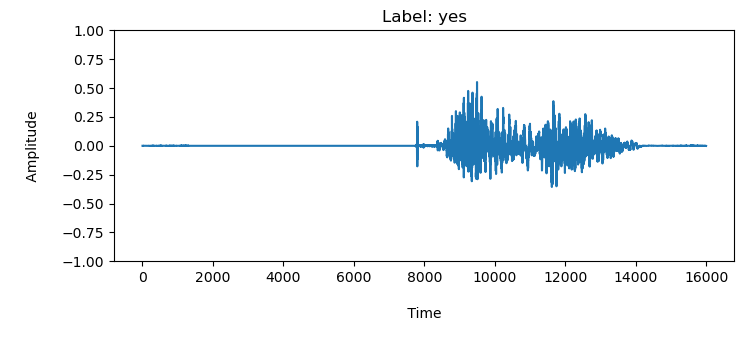

In [22]:
fig, ax = plt.subplots(figsize = (8, 3))

plot_audio(ax, audio_batch[2], label_batch[2])

#### Mel Spectrogram and MFCCs

In [23]:
def plot_spect(spect, title = 'Spectrogram', ax = None, conv_log = False):

    if len(spect.shape) > 2: spect = tf.squeeze(spect)
    if conv_log: spect = np.log(spect + np.finfo(float).eps)

    time_lim, freq_lim = spect.shape[0], spect.shape[1]

    #time_vals = np.linspace(0, np.size(spect), num = time_lim, dtype = int)
    time_vals = np.linspace(0, time_lim, num = time_lim)
    freq_vals = range(freq_lim)

    if not ax: fig, ax = plt.subplots(figsize = (8, 3))

    ax.pcolormesh(time_vals, freq_vals, np.array(spect).T)
    ax.set_title(title)
    ax.set(xlabel = 'Time Bins', ylabel = 'Frequency Bins')

In [24]:
def get_spectrogram(audio, label, frame_length, frame_step, 
                        filt_noise = False, filt_thresh = 50, 
                        add_noise = False, add_noise_thresh = 1e2, 
                        norm_audio = False, 
                        plot = False, ylim = (-1, 1)):

    #To Filter the noise and obtain a clean signal
    if filt_noise:
        audio_max = tf.math.reduce_max(tf.abs(audio))   #Maximum (absolute) value of audio signal
        audio_threshold = audio_max / filt_thresh       #Fix the threshold below which all values will be filtered out

        mask = tf.less(tf.abs(audio), audio_threshold)  #Filtering mask

        #Filter audio, and add small factor so that there are no zeros that might blow up FFT
        audio = tf.where(mask, tf.zeros_like(audio) + 1e-8, audio)

    #Adding white gaussian noise
    if add_noise:
        noise = tf.random.normal([sample_rate,], mean = 0, stddev = 1)                          #Generate noise
        noise_max, audio_max = tf.math.reduce_max(noise), tf.math.reduce_max(tf.abs(audio))     #Get the maximum values of noise, audio
        noise_norm = (noise / noise_max) * (audio_max / add_noise_thresh)                       #Standardize the noise below a threshold of audio
        audio += noise_norm

    #Normalize the audio
    if norm_audio: audio /= np.max(np.abs(audio))

    #Apply short time fourier transform
    spect = tf.signal.stft(audio, frame_length = frame_length, 
                                    frame_step = frame_step,
                                    window_fn = tf.signal.hamming_window)
    spect = tf.abs(spect)
    
    print(f'Shape of matrix: {spect.shape}')

    if plot:

        #Converting to log scale
        log_spect = np.log(spect + np.finfo(float).eps)

        #Plotting Spectrogram
        fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))

        fig.tight_layout(pad = 6)
        
        plot_audio(ax[0], audio, label, ylim)
        plot_spect(log_spect, ax = ax[1]) 

    return(spect)

In [25]:
def conv_to_mel(spect, num_mel_bins, lower_edge_hertz, upper_edge_hertz, 
                get_mfccs = False, num_mfccs = 13, 
                plot = False):

    #Gets number of stft frequency bins
    num_spect_bins = spect.shape[-1]

    #Matrix for converting from stft to mel space
    linear_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
                            num_mel_bins,
                            num_spect_bins,
                            sample_rate,
                            lower_edge_hertz,
                            upper_edge_hertz)

    #Obtaining Spectrogram
    mel_spect = tf.tensordot(spect, linear_to_mel_matrix, 1)
    log_mel_spect = tf.math.log(mel_spect + 1e-8)

    #Plotting Spectrogram
    if plot: plot_spect(log_mel_spect, title = 'Mel Spectrogram \n')

    if get_mfccs:
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spect)[..., 1:num_mfccs]  #Get the first thirteen coefficients, and ignore the first one
        return mfccs

    return(log_mel_spect)

In [78]:
spect = get_spectrogram(audio_batch[15], label_batch[15], 
                            frame_length = 400, frame_step = 160, 
                            filt_noise = False, filt_thresh = 50,
                            add_noise = True, add_noise_thresh = 1e2,
                            norm_audio = False,
                            plot = False)

Shape of matrix: (98, 257)


TensorShape([98, 40])

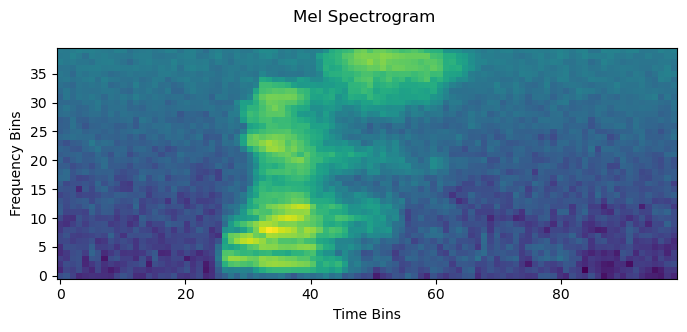

In [79]:
num_mel_bins = 40

lower_edge_hertz = 20 #Lower limit of human hearing
upper_edge_hertz = sample_rate // 2 #Nyquist frequency

num_mfccs = 13

log_mel_spect = conv_to_mel(spect,
                                num_mel_bins,
                                lower_edge_hertz,
                                upper_edge_hertz,
                                get_mfccs = False,
                                num_mfccs = num_mfccs,
                                plot = True)

log_mel_spect.shape

#### Calculating all MFCC coefficients (Energy, Delta, Delta-Delta)

In [28]:
# Padding a tensor along axis = 0
# Done to account for edge cases while applying delta function
def pad_tensor(tensor, N, shape_factor):

    shape = np.array(tensor.shape)
    shape = shape[shape != None]

    repeat_counts = [N+1] + [1 for i in range(shape[0]-2)] + [N+1]
    tensor_padded = tf.repeat(tensor, repeats = repeat_counts, axis = 0 + shape_factor)
    
    return(tensor_padded)


# Applying the local derivative to padded tensor
def delta_function(tensor_padded, N, shape_factor):

    #Accounting for parallelizability case (where shape = (None, dim1, dim2))
    shape = np.array(tensor_padded.shape)
    shape = shape[shape != None]

    #Defining delta
    delta = None
    
    #Defining denominator
    delta_denom = (1/3)*N*(N+1)*(2*N+1)

    #Accounting for the padding, we construct the delta 
    for mfcc_pos in range(N, shape[0] - N):

        #Gets tensor slices to the right and left of the current position
        right_slice = tf.gather(tensor_padded, indices = range(mfcc_pos + 1, mfcc_pos + N + 1), axis = 0 + shape_factor)
        left_slice = tf.gather(tensor_padded, indices = range(mfcc_pos - N, mfcc_pos), axis = 0 + shape_factor)

        #Sums over the tensor slices
        right_sum = tf.math.reduce_sum(right_slice, axis = 0 + shape_factor)
        left_sum = tf.math.reduce_sum(left_slice, axis = 0 + shape_factor)

        #Gets the difference between the right and left slice sums
        diff = tf.expand_dims(right_sum - left_sum, axis = 0 + shape_factor)

        if delta is None: delta = diff / delta_denom
        else: delta = tf.concat([delta, diff / delta_denom], axis = 0 + shape_factor)
        
    return(delta)

In [29]:
#Calculating remaining coefficients (Energy, delta, delta-delta) and concatenating
# Argument N refers to the number of frames (mfccs) considered when calculating the delta
def mfcc_complete(mfccs, N = 2):

    if mfccs.shape[0] is None: shape_factor = 1
    else: shape_factor = 0

    #Calculating delta coefficients
    #Padding to account for edge cases when using delta function
    mfccs_padded = pad_tensor(mfccs, N, shape_factor)
    #print(f'Previous shape: {mfccs.shape}\nShape after padding: {mfccs_padded.shape}\n')
    
    delta = delta_function(mfccs_padded, N, shape_factor)
    #print('Shape of delta coefficients: ', delta.shape)

    #Calculating delta-delta coefficients
    delta_padded = pad_tensor(delta, N, shape_factor)
    delta_delta = delta_function(delta_padded, N, shape_factor)
    #print('Shape of delta_delta coefficients: ', delta_delta.shape)

    #Calculating energy coefficient for mfcc
    mfcc_energy = tf.math.reduce_sum(tf.square(mfccs), axis = 1 + shape_factor)
    mfcc_energy = tf.expand_dims(mfcc_energy, axis = 1 + shape_factor)
    #print('\nShape of Energy (MFCC): ', mfcc_energy.shape)

    #Calculating energy coefficient for delta
    mfcc_energy_padded = pad_tensor(mfcc_energy, N, shape_factor)
    delta_energy = delta_function(mfcc_energy_padded, N, shape_factor)
    #print('Shape of Energy (Delta): ', delta_energy.shape)

    #Calculating energy coefficient for delta-delta
    delta_energy_padded = pad_tensor(delta_energy, N, shape_factor)
    delta_delta_energy = delta_function(delta_energy_padded, N, shape_factor)
    #print('Shape of Energy (Delta-Delta): ', delta_energy.shape)

    #Concatenating all the coefficients per time frame
    mfccs_concat = tf.concat([mfccs, delta, delta_delta, mfcc_energy, delta_energy, delta_delta_energy], axis = 1 + shape_factor)
    #print('\nFinal shape of MFCC matrix: ', mfccs_concat.shape)

    return(mfccs_concat)

In [30]:
mfccs_concat = mfcc_complete(log_mel_spect, N = 2)
mfccs_concat.shape

TensorShape([98, 39])

#### Stacking MFCCs

In [37]:
def mfccs_stack(frames, stack_left, stack_right, stack_padding = True):

    #Accounting for the parallelizing case when shape is (None, dim1, dim2)
    if frames.shape[0] is None: shape_factor = 1
    else: shape_factor = 0

    if stack_padding:
        #Padding the frames (along time) to make stacking easier
        repeat_list = [stack_left + 1] + [1 for i in range(frames.shape[0 + shape_factor] - 2)] + [stack_right + 1]
        frames_padded = tf.repeat(frames, repeats = repeat_list, axis = 0 + shape_factor)
    else:
        #If no padding, then we ignore the first few frames and the final few frames and stack on the rest of the frames
        #This results in the time dimension reducing, but with more reliable stackings, as we are not adding in aritifical pads
        frames_padded = frames
        frames = tf.gather(frames, indices = range(stack_left, frames.shape[0 + shape_factor] - stack_right), axis = 0 + shape_factor)
    
    # print('og shape: ', frames.shape)
    # print('padded shape: ', frames_padded.shape)

    #Defining a function to get slices from padded tensor
    frames_padded_slice = lambda pos: tf.gather(frames_padded, indices = range(pos, frames.shape[0 + shape_factor] + pos), axis = 0 + shape_factor)

    #Concatenating padded slices to original tensor from left and right
    frames_stack = frames
    for pos_left in range(stack_left): frames_stack = tf.concat([frames_padded_slice(pos_left), frames_stack], axis = 1 + shape_factor)
    #print('shape after left: ', frames_stack.shape)
    for pos_right in range(stack_right): frames_stack = tf.concat([frames_stack, frames_padded_slice(pos_right + stack_left + 1)], axis = 1 + shape_factor)
    # print('shape after right: ', frames_stack.shape)

    return(frames_stack)

In [ ]:
frames_stack = mfccs_stack(mfccs_concat, stack_left = 1, stack_right = 2, stack_padding = False)

#### Smoothening Spectrogram using Filters and Convolutions

To even out the spectrogram, we use convolutional filters.  We do this using a three phase approach:
- Gaussian Filter:  Smoothening using a Gaussian filter of size = 10, sigma = 1.  Since our spectrogram shape is (98, 40), taking a filter size of (10, 10) is a nice balance in smoothing out global features while at the same time not losing much of the local information.  

- Sobel Filter:  We take the sobel filter along the x and the y directions, which provides us the edge changes along the directions.  We then add these up to give a sharper, well-defined region around the speech.

- Gaussian Filter:  We finally smooth it out using a similar gaussian filter.

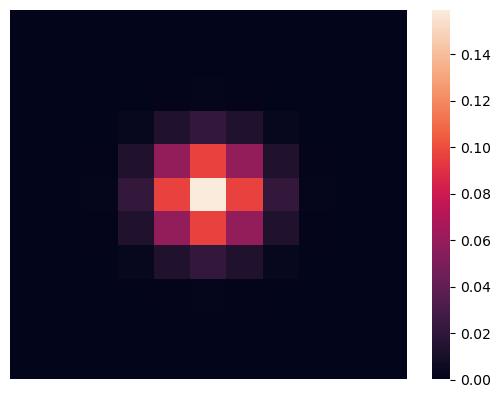

In [80]:
def get_gaussian_filter(size, sigma):
    
    half_size = size//2
    x_vals, y_vals = np.arange(-half_size, half_size+1), np.arange(-half_size, half_size+1)
    x_grid, y_grid = np.meshgrid(x_vals, y_vals)

    kernel = np.exp(-(x_grid**2 + y_grid**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)

    return(kernel)

def get_sobel_filter(direction = 'y'):

    if direction == 'y':
        return np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    if direction == 'x':
        return np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])


sns.heatmap(get_gaussian_filter(size = 10, sigma = 1))
plt.tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)

In [81]:
def tf_convolve(image, kernel, strides, padding = 'SAME'):
    
    #Convert image to shape (1, inp_height, inp_width, 1)
    image = tf.expand_dims(image, axis = 0)
    image = tf.expand_dims(image, axis = -1)

    #Convert kernel to shape (height, width, 1, 1)    
    kernel = tf.constant(kernel, dtype = float)
    kernel = tf.expand_dims(kernel, axis = -1)
    kernel = tf.expand_dims(kernel, axis = -1)

    #Convolution
    result = tf.nn.conv2d(image, kernel, [1, strides[0], strides[1], 1], padding)

    result = tf.squeeze(result, axis = 0)
    result = tf.squeeze(result, axis = -1)

    return result

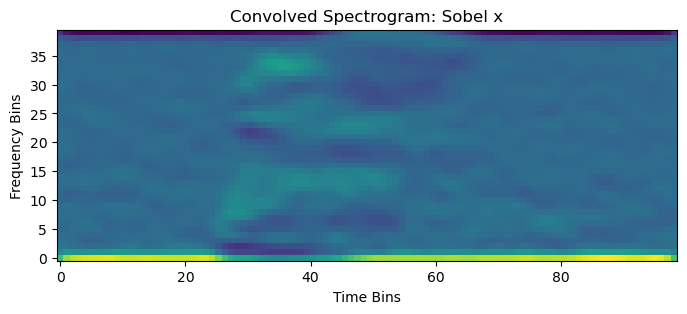

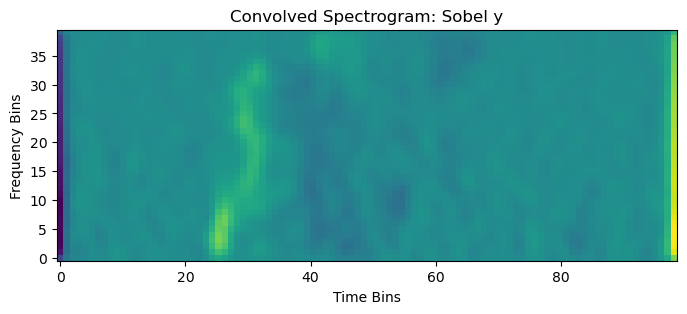

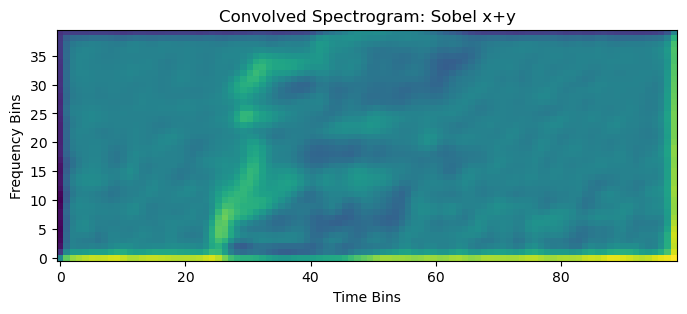

In [82]:
kernel_size = 10    #One-fourth of the size of frequency bins (40 bins)
kernel_sigma = 1    #We want most of the info to be smoothed, with only the central regions to stick out
gauss_kernel = get_gaussian_filter(kernel_size, kernel_sigma)

spect_gauss = tf_convolve(image = log_mel_spect, 
                                    kernel = gauss_kernel,
                                    strides = (1, 1), 
                                    padding = 'SAME')

sobel_kernel = np.array([   [1, 2, 1], 
                            [0, 0, 0], 
                            [-1, -2, -1]]) 

sobel_kernel = get_sobel_filter(direction = 'x')
spect_sobel_x = tf_convolve(image = spect_gauss, 
                                    kernel = sobel_kernel, 
                                    strides = (1, 1), 
                                    padding = 'SAME')

sobel_kernel = get_sobel_filter(direction = 'y')
spect_sobel_y = tf_convolve(image = spect_gauss, 
                                    kernel = sobel_kernel, 
                                    strides = (1, 1), 
                                    padding = 'SAME')

spect_sobel = spect_sobel_x + spect_sobel_y

plot_spect(spect_sobel_x, conv_log = False, title = 'Convolved Spectrogram: Sobel x')
plot_spect(spect_sobel_y, conv_log = False, title = 'Convolved Spectrogram: Sobel y')
plot_spect(spect_sobel, conv_log = False, title = 'Convolved Spectrogram: Sobel x+y')

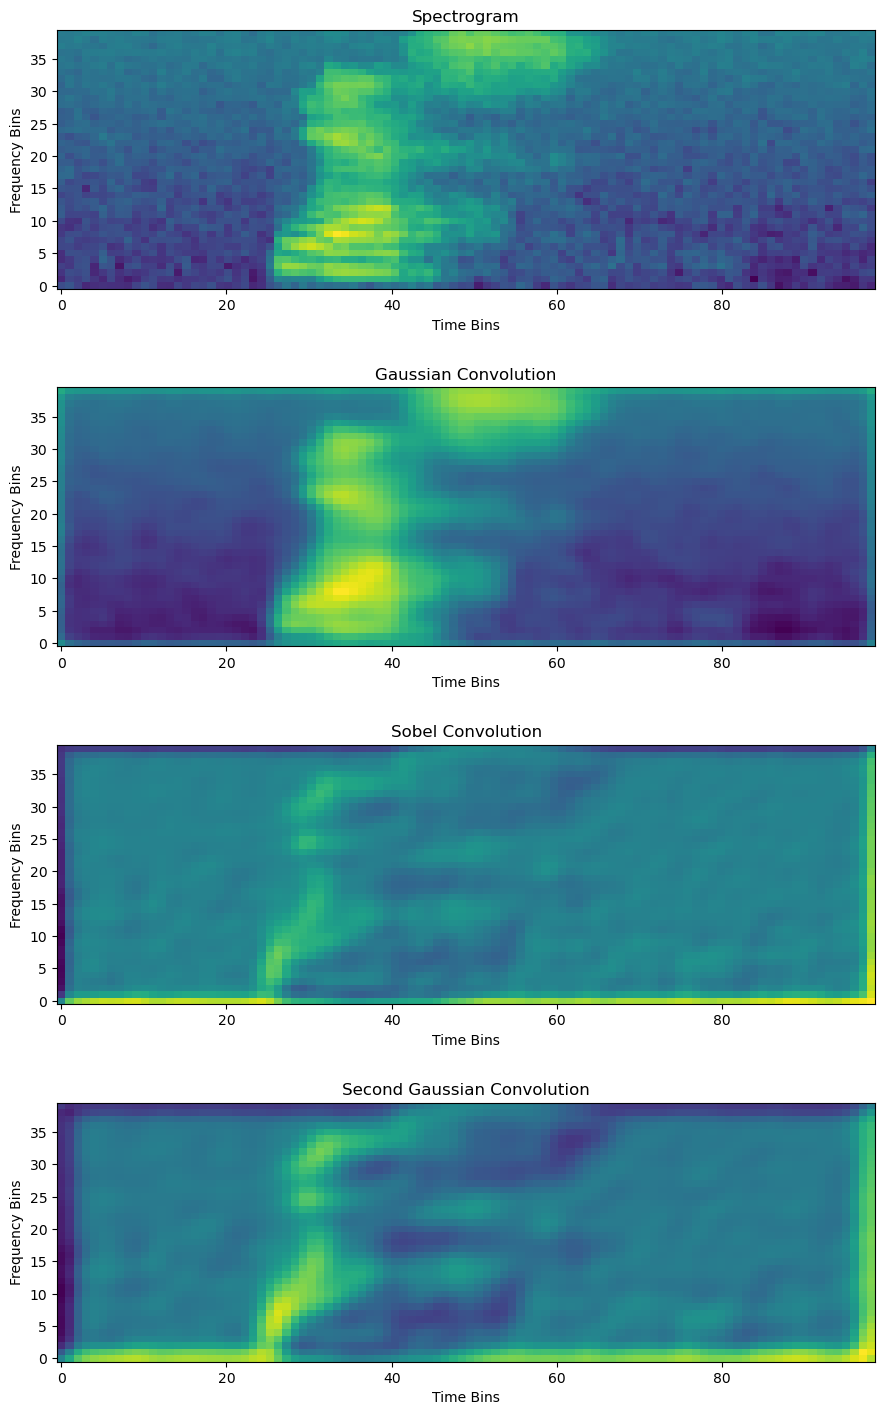

In [83]:
kernel_size = 10
kernel_sigma = 1
gauss_kernel = get_gaussian_filter(kernel_size, kernel_sigma)

spect_gauss_2 = tf_convolve(image = spect_sobel, 
                                    kernel = gauss_kernel,
                                    strides = (1, 1), 
                                    padding = 'SAME')

fig, ax = plt.subplots(nrows = 4, figsize = (10, 15))
fig.tight_layout(pad = 5)

plot_spect(log_mel_spect, ax = ax[0])
plot_spect(spect_gauss, ax = ax[1], title = 'Gaussian Convolution')
plot_spect(spect_sobel, ax = ax[2], title = 'Sobel Convolution')
plot_spect(spect_gauss_2, ax = ax[3], title = 'Second Gaussian Convolution')

In [84]:
def convolve_spect(log_mel_spect, 
                    gauss_size = 10, gauss_sigma = 1, 
                    apply_sobel = True):

    #First Convolution (Smoothing): Gaussian
    gauss_kernel = get_gaussian_filter(size = gauss_size, sigma = gauss_sigma)

    spect_gauss = tf_convolve(image = log_mel_spect, 
                                        kernel = gauss_kernel,
                                        strides = (1, 1), 
                                        padding = 'SAME')
    
    if apply_sobel:

    
        #Second Convolution (Frequency Distinction): Sobel x + Sobel y
        sobel_kernel = get_sobel_filter(direction = 'x')
        spect_sobel_x = tf_convolve(image = spect_gauss, 
                                            kernel = sobel_kernel, 
                                            strides = (1, 1), 
                                            padding = 'SAME')

        sobel_kernel = get_sobel_filter(direction = 'y')
        spect_sobel_y = tf_convolve(image = spect_gauss, 
                                            kernel = sobel_kernel, 
                                            strides = (1, 1), 
                                            padding = 'SAME')
        
        spect_sobel = spect_sobel_x + spect_sobel_y


        #Third Convolution (Smoothing): Gaussian
        gauss_kernel_2 = get_gaussian_filter(size = gauss_size, sigma = gauss_sigma)

        spect_gauss_2 = tf_convolve(image = spect_sobel, 
                                            kernel = gauss_kernel_2,
                                            strides = (1, 1), 
                                            padding = 'SAME')
        
        return(spect_gauss_2)
    
    return(spect_gauss)


(98, 40)


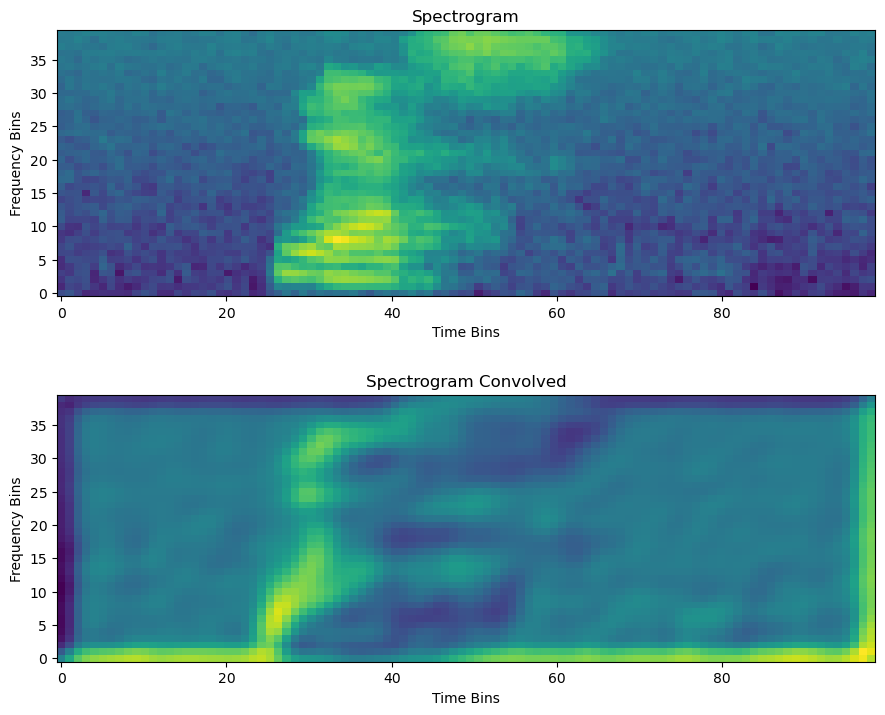

In [92]:
spect_conv = convolve_spect(log_mel_spect,
                                gauss_size = 10,gauss_sigma = 1,
                                apply_sobel=True)


fig, ax = plt.subplots(nrows = 2, figsize = (10, 8))
fig.tight_layout(pad = 5)

plot_spect(log_mel_spect, ax = ax[0])
plot_spect(spect_conv, ax = ax[1], title = 'Spectrogram Convolved')
print(spect_conv.shape)

#### Converting datasets to mel spectrogram datasets

In [93]:
def map_audio_to_spect(data, 
                        frame_length, frame_step, 
                        filt_noise, filt_thresh,
                        add_noise, add_noise_thresh,
                        num_mel_bins, lower_edge_hertz, upper_edge_hertz, 
                        get_mfccs, num_mfccs, delta_padding,
                        stack_left, stack_right, stack_padding):

        #Get Spectrogram
        spect = lambda audio: get_spectrogram(audio, None, 
                                    frame_length, frame_step, 
                                    filt_noise, filt_thresh,
                                    add_noise, add_noise_thresh)

        #Convert to either log mel spect or mfccs
        log_mel_spect = lambda spect: conv_to_mel(spect, num_mel_bins, 
                                            lower_edge_hertz, upper_edge_hertz, 
                                            get_mfccs, num_mfccs)

        if get_mfccs:   #Get all mfcc coefficients
            final_result = lambda log_mel_spect: mfccs_stack(mfcc_complete(log_mel_spect, N = delta_padding), 
                                                                stack_left, stack_right, stack_padding)[..., tf.newaxis]
        else:   #Convolve spect applying either gaussian or sobel filters
            final_result = lambda log_mel_spect: convolve_spect(log_mel_spect)[..., tf.newaxis]
        
        #Map parallely
        return data.map(map_func = lambda audio, label : (final_result(log_mel_spect(spect(audio))), label), 
                            num_parallel_calls = tf.data.AUTOTUNE)

In [94]:
frame_length_time, frame_step_time = 25, 10 #In milli-seconds

frame_length = int(0.001 * sample_rate * frame_length_time)
frame_step = int(0.001 * sample_rate * frame_step_time)
filt_noise, filt_thresh = False, 50
add_noise, add_noise_thresh = True, 1e2

num_mel_bins = 40                       
lower_edge_hertz = 20                   #Lower limit of human hearing
upper_edge_hertz = sample_rate // 2     #Nyquist Frequency

get_mfccs = False
num_mfccs = 13  
delta_padding = 2     #Number of frames (mfccs) to consider when calculating the delta
stack_left, stack_right, stack_padding = 5, 5, False     #Frames to stack on left and right, Whether to apply frame padding or not

print(f'Frame Length (in samples): {frame_length}, Frame Stride (in samples): {frame_step}')

get_spect_ds = lambda data: map_audio_to_spect(data, 
                                                    frame_length, frame_step, 
                                                    filt_noise, filt_thresh,                                                    
                                                    add_noise, add_noise_thresh,
                                                    num_mel_bins, lower_edge_hertz, upper_edge_hertz,
                                                    get_mfccs, num_mfccs, delta_padding,
                                                    stack_left, stack_right, stack_padding)

train_spect_ds = get_spect_ds(train_data)
val_spect_ds = get_spect_ds(val_data)
test_spect_ds = get_spect_ds(test_data)

Frame Length (in samples): 400, Frame Stride (in samples): 160
Shape of matrix: (None, 98, 257)
Shape of matrix: (None, 98, 257)
Shape of matrix: (None, 98, 257)


In [95]:
valid_data = val_spect_ds.map(lambda audio, label: audio)
valid_labels = val_spect_ds.map(lambda audio, label: label)

val_labels_arr = np.concatenate(np.array([batch_labels for batch_labels in valid_labels]), axis =  0)
val_labels_arr.shape

(1184, 8)

In [96]:
get_shapes(train_spect_ds)

Number of Training Batches: 175
Shape of audio data in batch: (32, 98, 40, 1)
Shape of labels in batch: (32, 8)


In [97]:
get_shapes(val_spect_ds)

Number of Training Batches: 37
Shape of audio data in batch: (32, 98, 40, 1)
Shape of labels in batch: (32, 8)


In [98]:
get_shapes(test_spect_ds)

Number of Training Batches: 38
Shape of audio data in batch: (32, 98, 40, 1)
Shape of labels in batch: (32, 8)


#### Plot the new datasets

In [99]:
for sample_spect, sample_label in train_spect_ds:
    break

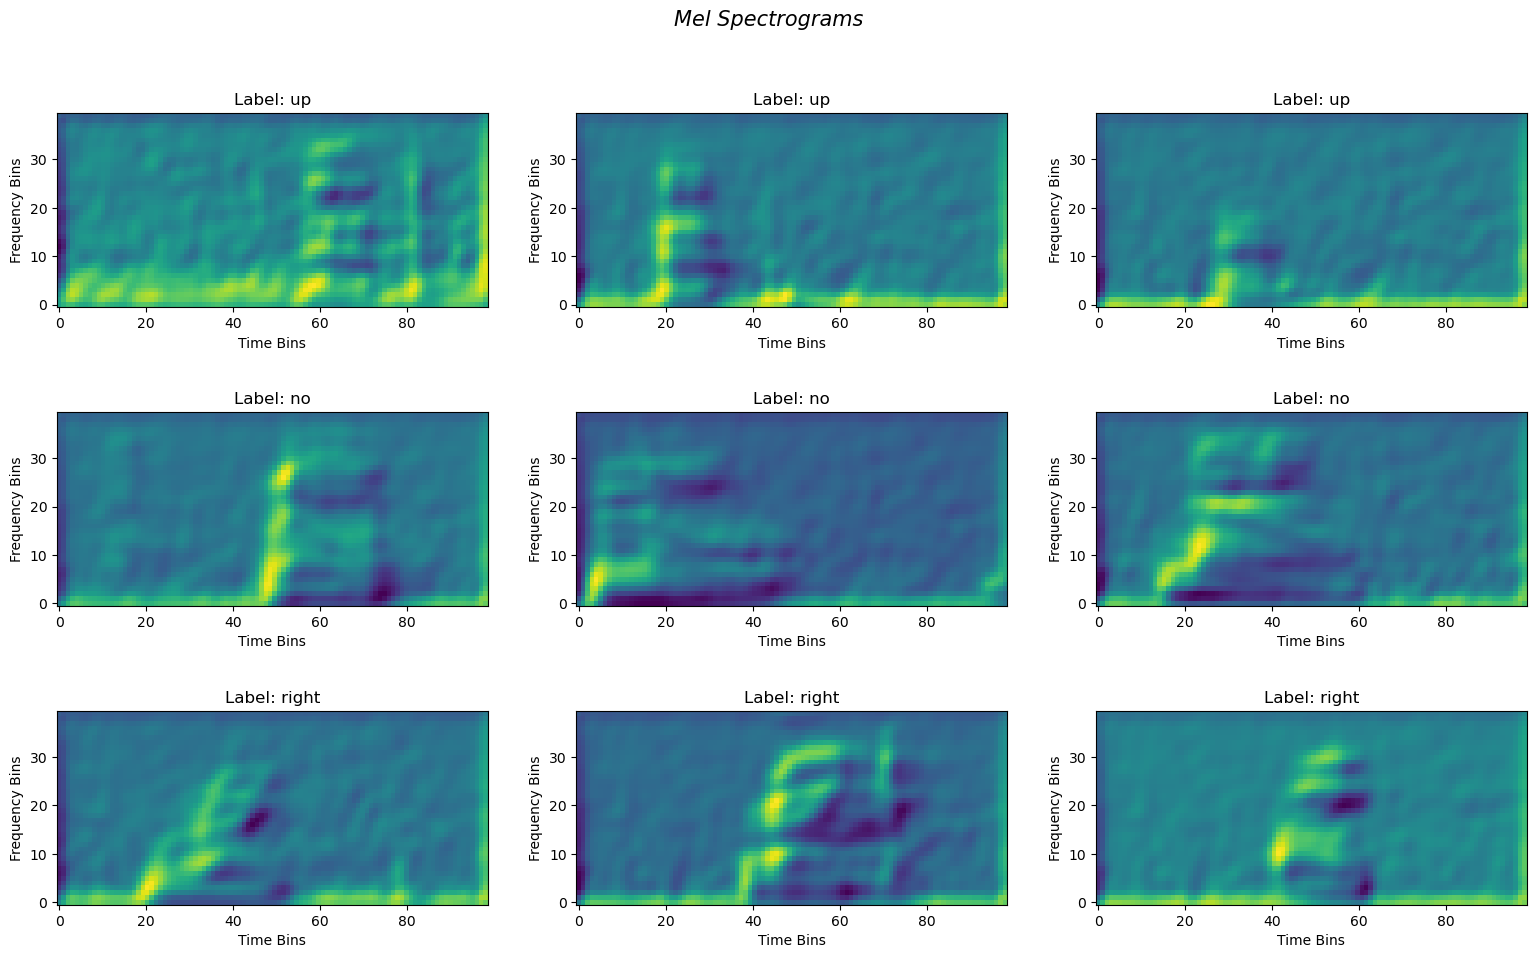

In [103]:
#Select labels for plotting, number of plots for each label
plot_labels = ['up', 'no', 'right']
plot_num = 3

#Obtain positions for selected labels
plot_labels_pos = [np.where(labels == elem)[0][0] for elem in plot_labels]

#Function for obtaining label counts in a batch
def get_labels_counts(label_list, ref_labels):
    uniqs, counts = np.unique(label_list, return_counts = True)

    uniqs_pos = [np.where(uniqs == l)[0][0] for l in ref_labels]
    ref_labels_counts = counts[uniqs_pos]
    return(ref_labels_counts)

batch = 0
for sample_spect, sample_label in train_spect_ds:

    batch += 1

    #Decode one hot encoding
    sample_label_decoded = decode_one_hot(sample_label)

    #Check if the ref labels are in the sample_label batch, if not, continue to the next batch
    check_presence = [ref_label in sample_label_decoded for ref_label in plot_labels_pos]
    if sum(check_presence) < 3: continue

    #Get ref label counts in the batch
    plot_labels_counts = get_labels_counts(sample_label_decoded, plot_labels_pos)
    if min(plot_labels_counts) >= plot_num: break

#print(plot_labels_counts)

#Obtain plot matrix positions
plot_labels_matrix = np.array([np.where(sample_label_decoded == l)[0][:plot_num] for l in plot_labels_pos])
#print(plot_labels_matrix)

#Plotting
fig, ax = plt.subplots(nrows = len(plot_labels), ncols = plot_num, figsize = (16, 10))

for i in range(len(plot_labels)):
    for j in range(plot_num):
        plot_spect(sample_spect[plot_labels_matrix[i, j]],
                    title = f'Label: {labels[sample_label_decoded[plot_labels_matrix[i, j]]]}',
                    ax = ax[i, j])

fig.suptitle('Mel Spectrograms', fontsize = 15, style = 'italic')
fig.tight_layout(pad = 3)

## Building Model

In [104]:
#Using cache and prefetch to speed up reading data

train_spect_ds = train_spect_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spect_ds = val_spect_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spect_ds = test_spect_ds.cache().prefetch(tf.data.AUTOTUNE)


In [108]:
input_shape = get_shapes(train_spect_ds, return_shape = True)[1:]
print('\nInput Shape: ', input_shape)

n_labels = len(labels)
print('Number of labels: ', n_labels)

#Scales each training set to the global mean and variance
norm_layer = layers.Normalization()
norm_layer.adapt(data = train_spect_ds.map(map_func = lambda spect, label: spect))

Number of Training Batches: 175
Shape of audio data in batch: (32, 98, 40, 1)
Shape of labels in batch: (32, 8)

Input Shape:  (98, 40, 1)
Number of labels:  8


#### Creating LoRA Layer for Keras

In [106]:
#Constructing a LoRA class, which helps in reducing number of parameters
class Linear_LoRA(layers.Layer):
    def __init__(self, units, rank):
        super().__init__(name = 'Linear_LoRA', trainable = True)
        self.units = units
        self.rank = rank

    def build(self, input_shape):

        self.matrix_A = self.add_weight(
                            shape = (input_shape[-1], self.rank),
                            trainable = True,
                            name = 'weights_matrix_A'
        )

        self.matrix_B = self.add_weight(
                            shape = (self.rank, self.units),
                            trainable = True,
                            name = 'weight_matrix_B'
        )

        self.bias = self.add_weight(
                        shape = (self.units,),
                        initializer = 'zeros',
                        trainable = True,
                        name = 'bias'
        )

    def call(self, input):
        output = tf.matmul(tf.matmul(input, self.matrix_A), self.matrix_B) + self.bias
        return output

#### CNN

##### Traditional CNN

In [ ]:
cnn_trad_fpool3 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 64, kernel_size = ((input_shape[0]*2)//3, 8), strides = (1, 1)),
    layers.MaxPooling2D(pool_size = (1, 3), strides = (1, 3)),

    layers.Conv2D(filters = 64, kernel_size = (input_shape[0]//3, 4), strides = (1, 1)),

    layers.Flatten(),   
    
    #Linear Low-Rank Layer
    Linear_LoRA(units = 32, rank = 32),
    
    layers.Dense(128, activation = 'relu'),

    layers.Dense(n_labels, activation = 'softmax')
])

cnn_trad_fpool3.summary()

##### CNN: Limiting Multiplies

Here, we get rid of the pooling layer (this reduces multiplies) and increases the stride length (this reduces the parameters and multiplies).

In [ ]:
cnn_one_fstride4 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 186, kernel_size = (input_shape[0], 8), strides = (1, 4)),

    layers.Flatten(),   
    
    #Linear Low Rank Layer
    Linear_LoRA(units = 32, rank = 32),
    
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(n_labels, activation = 'softmax')
    
])

cnn_one_fstride4.summary()


In [ ]:
cnn_one_fstride8 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 336, kernel_size = (input_shape[0], 8), strides = (1, 8)),

    layers.Flatten(),   
    
    #Linear Low Rank Layer
    Linear_LoRA(units = 32, rank = 32),
    
    layers.Dense(128, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(n_labels, activation = 'softmax')
    
])

cnn_one_fstride8.summary()

##### CNN: Limiting Parameters

Here, we are only concerned with limiting parameters.  We use pooling and striding, trying to limit parameters, while the multiplies have no restriction to it.

In [ ]:
cnn_tstride2 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 78, kernel_size = (input_shape[0]//2, 8), strides = (2, 1)),
    layers.MaxPooling2D(pool_size = (1, 3), strides = (1, 3)),

    layers.Conv2D(filters = 78, kernel_size = (input_shape[0]//4, 4), strides = (1, 1)),
    layers.MaxPooling2D(pool_size = (1, 1), strides = (1, 1)),

    layers.Flatten(),   
    
    #Linear Low Rank Layer
    Linear_LoRA(units = 32, rank = 32),
    
    layers.Dense(128, activation = 'relu'),
    layers.Dense(n_labels, activation = 'softmax')
    
])

cnn_tstride2.summary()

In [ ]:
cnn_tstride4 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 100, kernel_size = (input_shape[0]//2, 8), strides = (4, 1)),
    layers.MaxPooling2D(pool_size = (1, 3), strides = (1, 3)),

    layers.Conv2D(filters = 78, kernel_size = (input_shape[0]//8, 4), strides = (1, 1)),
    layers.MaxPooling2D(pool_size = (1, 1), strides = (1, 1)),

    layers.Flatten(),   
    
    #Linear Low Rank Layer
    Linear_LoRA(units = 32, rank = 32),
    
    layers.Dense(128, activation = 'relu'),
    layers.Dense(n_labels, activation = 'softmax')
    
])

cnn_tstride4.summary()

In [ ]:
cnn_tstride8 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 126, kernel_size = (input_shape[0]//2, 8), strides = (8, 1)),
    layers.MaxPooling2D(pool_size = (1, 3), strides = (1, 3)),

    layers.Conv2D(filters = 78, kernel_size = (5, 4), strides = (1, 1)),
    layers.MaxPooling2D(pool_size = (1, 1), strides = (1, 1)),

    layers.Flatten(),   
    
    #Linear Low Rank Layer
    Linear_LoRA(units = 32, rank = 32),
    
    layers.Dense(128, activation = 'relu'),
    layers.Dense(n_labels, activation = 'softmax')
    
])

cnn_tstride8.summary()

In [ ]:
cnn_tpool2 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 94, kernel_size = (21, 8), strides = (1, 1)),
    layers.MaxPooling2D(pool_size = (2, 3), strides = (2, 3)),

    layers.Conv2D(filters = 94, kernel_size = (6, 4), strides = (1, 1)),
    layers.MaxPooling2D(pool_size = (1, 1), strides = (1, 1)),

    layers.Flatten(),   
    
    #Linear Low Rank Layer
    Linear_LoRA(units = 32, rank = 32),
    
    layers.Dense(128, activation = 'relu'),
    layers.Dense(n_labels, activation = 'softmax')
    
])

cnn_tpool2.summary()

In [109]:
cnn_tpool3 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Conv2D(filters = 94, kernel_size = (15, 8), strides = (1, 1)),
    layers.MaxPooling2D(pool_size = (3, 3), strides = (3, 3)),

    layers.Conv2D(filters = 94, kernel_size = (6, 4), strides = (1, 1)),
    layers.MaxPooling2D(pool_size = (1, 1), strides = (1, 1)),

    layers.Flatten(),   
    
    #Linear Low Rank Layer
    Linear_LoRA(units = 32, rank = 32),
    
    layers.Dense(128, activation = 'relu'),
    layers.Dense(n_labels, activation = 'softmax')
    
])

cnn_tpool3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 84, 33, 94)        11374     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 11, 94)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 8, 94)         212158    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 8, 94)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 17296)             0         
                                                                 
 Linear_LoRA (Linear_LoRA)   (None, 32)               

#### DNN

Here, we implement a classic DNN architecture with 3 layers of 128 nodes each.

In [ ]:
dnn_3x128 = models.Sequential([
    layers.Input(shape = input_shape),

    layers.Flatten(),

    layers.Dense(128, activation = 'relu'),

    layers.Dense(128, activation = 'relu'),

    layers.Dense(128, activation = 'relu'),

    layers.Dense(n_labels, activation = 'softmax')
])

dnn_3x128.summary()

## Training Model

#### Training

In [111]:
model = cnn_tpool3
model_name = 'cnn_tpool3'

model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['categorical_accuracy', tf.keras.metrics.AUC(multi_label = True, num_labels = len(labels))],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv2d_2 (Conv2D)           (None, 84, 33, 94)        11374     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 11, 94)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 8, 94)         212158    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 8, 94)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 17296)             0         
                                                                 
 Linear_LoRA (Linear_LoRA)   (None, 32)                554528    
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
          

In [112]:
class val_pred_hist(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        
        if not logs:
            logs = {'val_preds': self.model.predict(valid_data)}

        elif 'val_preds' not in logs.keys():
            logs['val_preds'] = self.model.predict(valid_data)

        else:
            logs['val_preds'].append(self.model.predict(valid_data))

In [113]:
EPOCHS = 25

history = model.fit(
    train_spect_ds,
    validation_data=val_spect_ds,
    epochs=EPOCHS,
    shuffle = True,                     #Shuffles the data
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy', 
                                                mode='max', 
                                                min_delta = 0.01,
                                                patience = 5,
                                                verbose=1),
                val_pred_hist()]
)

Epoch 1/25


175/175 [==============================] - 26s 131ms/step - loss: 1.9068 - categorical_accuracy: 0.4173 - auc: 0.7872 - val_loss: 1.4416 - val_categorical_accuracy: 0.5228 - val_auc: 0.8687 - val_preds: 0.1250
Epoch 2/25
175/175 [==============================] - 21s 117ms/step - loss: 1.1170 - categorical_accuracy: 0.6334 - auc: 0.9119 - val_loss: 1.0916 - val_categorical_accuracy: 0.6647 - val_auc: 0.9240 - val_preds: 0.1250
Epoch 3/25
175/175 [==============================] - 21s 122ms/step - loss: 0.8914 - categorical_accuracy: 0.7188 - auc: 0.9436 - val_loss: 0.9888 - val_categorical_accuracy: 0.6985 - val_auc: 0.9395 - val_preds: 0.1250
Epoch 4/25
175/175 [==============================] - 20s 113ms/step - loss: 0.7476 - categorical_accuracy: 0.7673 - auc: 0.9589 - val_loss: 0.9507 - val_categorical_accuracy: 0.7280 - val_auc: 0.9429 - val_preds: 0.1250
Epoch 5/25
175/175 [==============================] - 19s 110ms/step - loss: 0.6664 - categorical_accuracy: 0.7987 - auc: 0.966

#### Metrics: Accuracy, Categorical Loss

In [114]:
metrics = history.history
metric_names = list(metrics.keys())
metric_names

['loss',
 'categorical_accuracy',
 'auc',
 'val_loss',
 'val_categorical_accuracy',
 'val_auc',
 'val_preds']

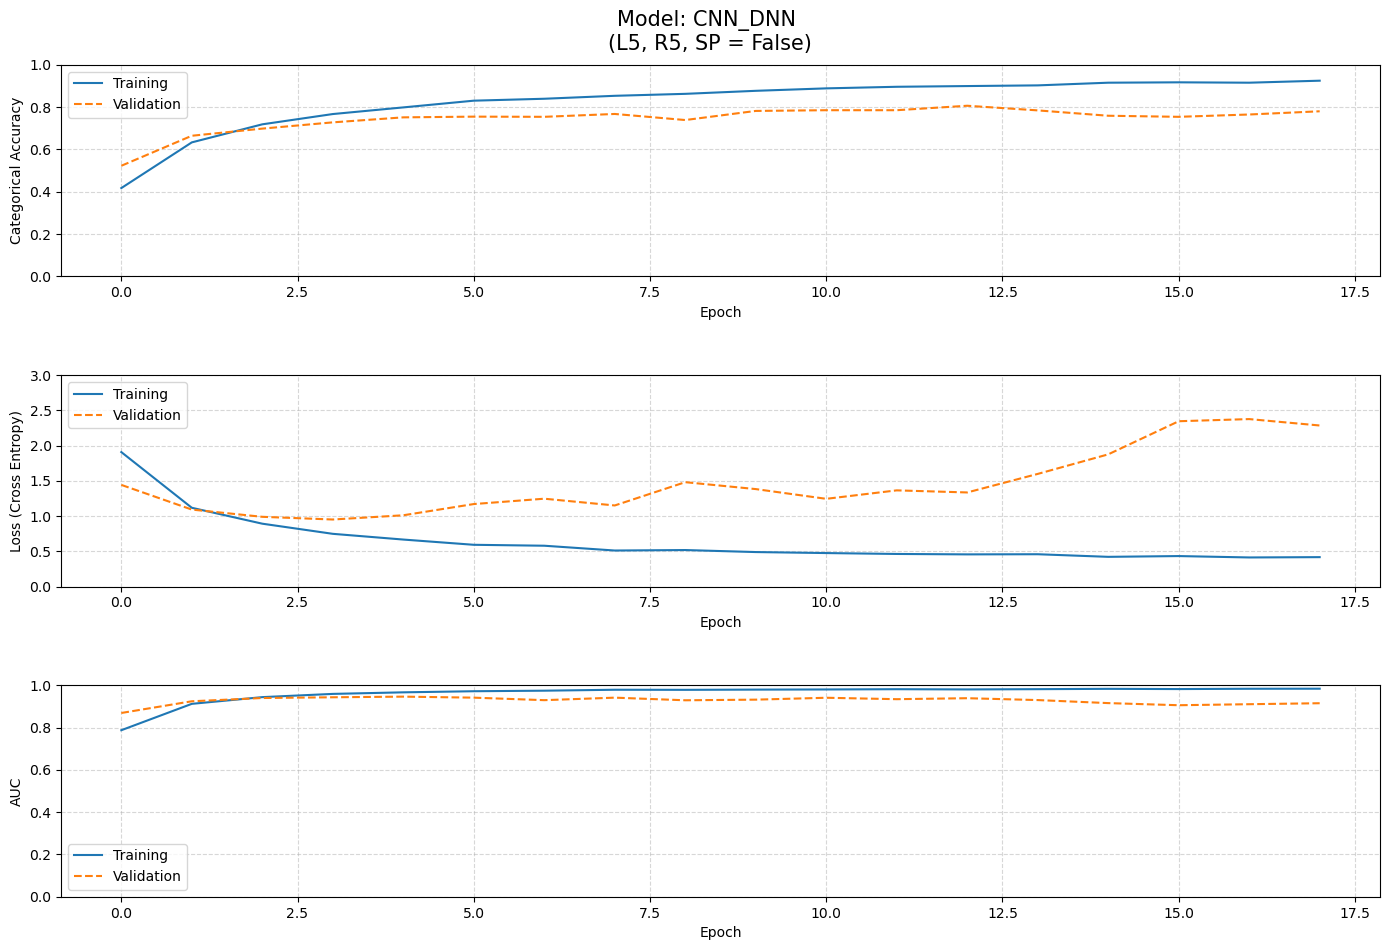

In [115]:
def plot_metric(ax, history, train, val, metric_label, ylim = (0, 1)):
    ax.plot(history.epoch, train)
    ax.plot(history.epoch, val, linestyle = '--')
    ax.legend(['Training', 'Validation'])
    ax.set(ylim = ylim, xlabel = 'Epoch', ylabel = metric_label)
    ax.grid(True, alpha = 0.5, linestyle = '--')


fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 10))
fig.tight_layout(pad = 5)
# fig.suptitle(f'Model: {model_name}', fontsize = 15)
fig.suptitle(f'Model: CNN_DNN \n(L5, R5, SP = False)', fontsize = 15)

plot_metric(ax[0], history, metrics['categorical_accuracy'], metrics['val_categorical_accuracy'], metric_label = 'Categorical Accuracy')
plot_metric(ax[1], history, metrics['loss'], metrics['val_loss'], metric_label = 'Loss (Cross Entropy)', ylim = (0, 3))
plot_metric(ax[2], history, metrics[metric_names[2]], metrics[metric_names[5]], metric_label = 'AUC')

#### Metrics: Precision, Recall, F1 per Label

In [116]:
def decode_batch_preds(pred_labels):

    #Convert predictions to one hot format (assigning 1 to the max and 0 to the rest)
    one_hot_max = lambda row: [1 if elem == np.max(row) else 0 for elem in row]
    pred_labels = np.apply_along_axis(one_hot_max, arr = pred_labels, axis = 1)

    #Decode the predictions
    pred_labels = decode_one_hot(pred_labels)
    return pred_labels

In [117]:
def get_metric_per_label(history, val_labels):

    #Convert validation labels from one hot to actual labels
    val_labels = decode_one_hot(val_labels)

    #Get model predictions per epoch
    val_preds_epoch = np.array(history.history['val_preds'])

    #Convert to one-hot and decode predictions
    n_epoch = val_preds_epoch.shape[0]
    val_preds_epoch = np.array([decode_batch_preds(val_preds_epoch[epoch]) for epoch in range(n_epoch)])

    #Obtain precision, recall and f1 scores
    precision_epoch, recall_epoch, f1_epoch = [], [], []

    for epoch in range(n_epoch):
        precision, recall, f1, _ = prf(val_labels, val_preds_epoch[epoch], labels = np.arange(8))

        precision_epoch.append(precision)
        recall_epoch.append(recall)
        f1_epoch.append(f1)
    
    return np.array(precision_epoch), np.array(recall_epoch), np.array(f1_epoch)

In [118]:
def plot_per_label(ax, metric_epoch, metric_name):

        #Get number of epochs
        epochs = np.arange(metric_epoch.shape[0])

        #Get the macro average
        macro_metric_epoch = np.mean(metric_epoch, axis = 1)

        #Plotting
        ax.plot(epochs, macro_metric_epoch, linestyle = '-', color = 'red', label = f'Macro-{metric_name}')
        ax.plot(epochs, metric_epoch, label = labels, alpha = 0.3, linestyle = '--')
        

        ax.set(ylim = (0, 1), 
                title = f'Validation {metric_name} \n',
                xlabel = '\n Epoch', 
                ylabel = f'{metric_name} \n')

        ax.grid(True, alpha = 0.5, linestyle = '--')
        ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), shadow = True)

In [119]:
#Get metric per label
precision_epoch, recall_epoch, f1_epoch = get_metric_per_label(history, val_labels_arr)

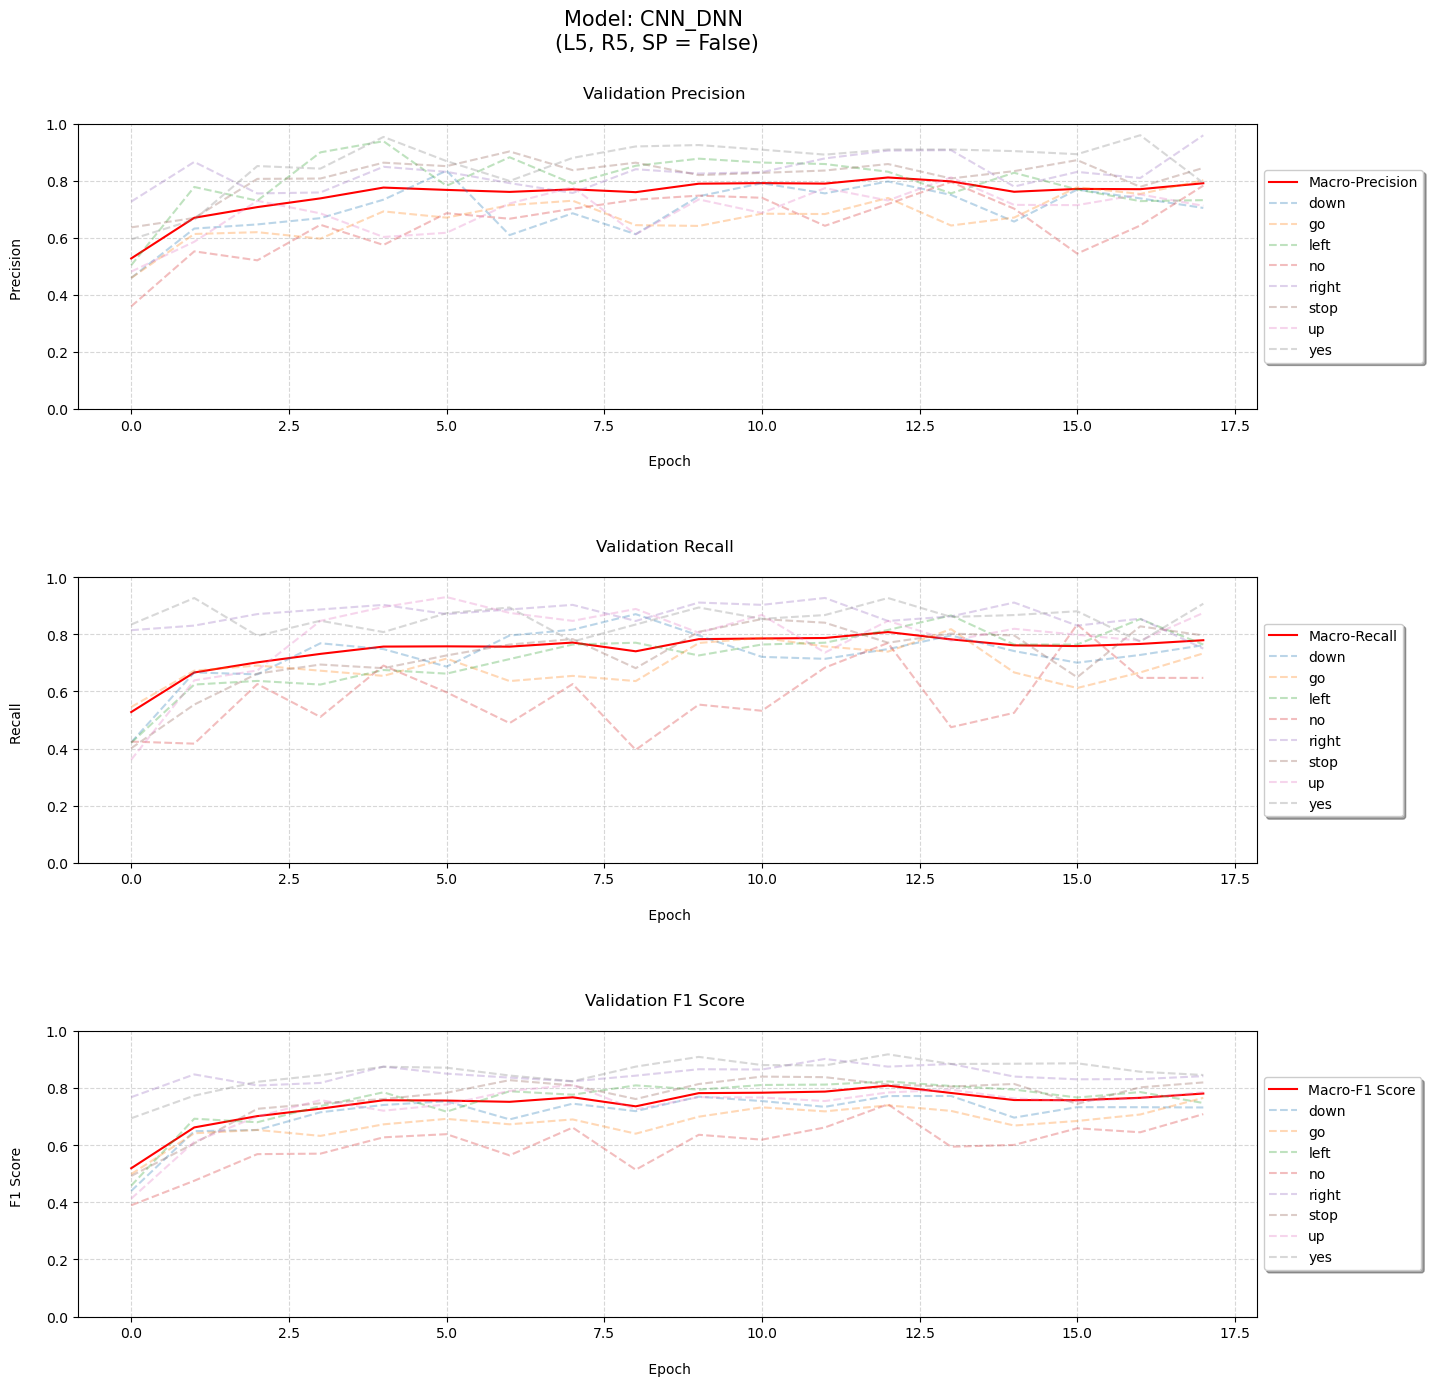

In [120]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 15))
fig.tight_layout(pad = 10)
fig.suptitle(f'Model: {model_name}', fontsize = 15)
fig.suptitle(f'Model: CNN_DNN \n(L5, R5, SP = False)', fontsize = 15)

plot_per_label(ax[0], precision_epoch, metric_name = 'Precision')
plot_per_label(ax[1], recall_epoch, metric_name = 'Recall')
plot_per_label(ax[2], f1_epoch, metric_name = 'F1 Score')

[Text(0.5, 1.0, 'F1 Score'), (0.0, 1.0)]

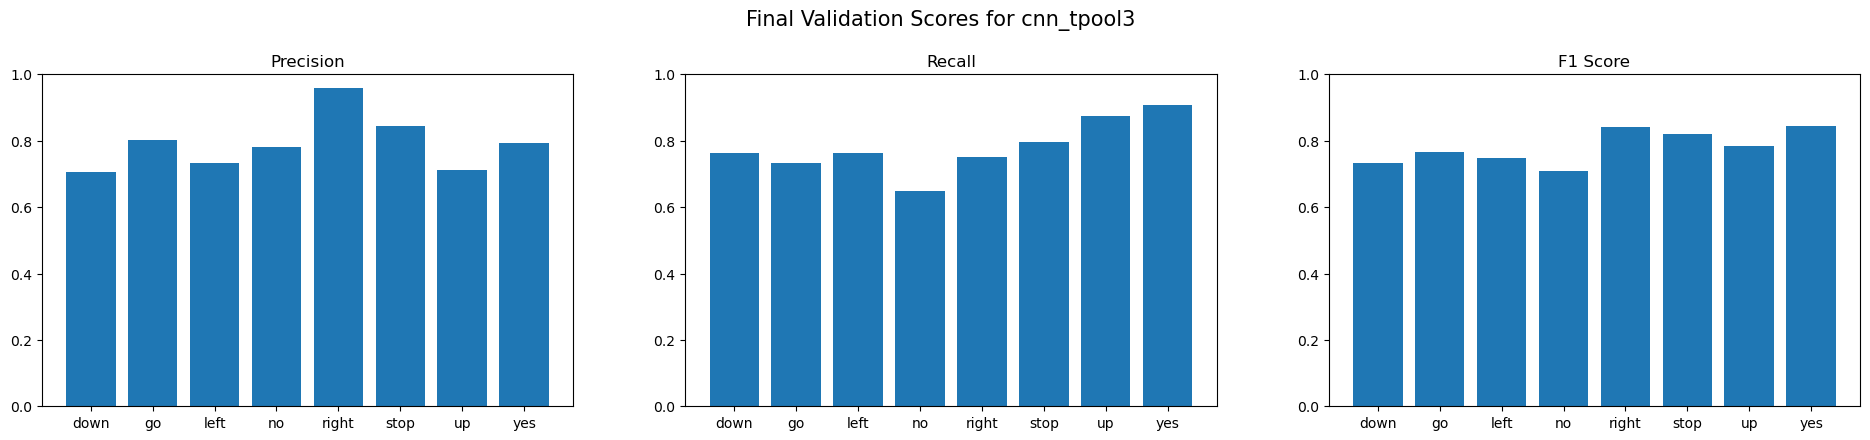

In [121]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))
fig.tight_layout(pad = 5)
fig.suptitle(f'Final Validation Scores for {model_name}', fontsize = 15)

ax[0].bar(labels, precision_epoch[-1])
ax[0].set(title = 'Precision', ylim = (0, 1))

ax[1].bar(labels, recall_epoch[-1])
ax[1].set(title = 'Recall', ylim = (0, 1))

ax[2].bar(labels, f1_epoch[-1])
ax[2].set(title = 'F1 Score', ylim = (0, 1))

## Hyper-Parameter Grid Search

In [ ]:
input_shape = get_shapes(train_spect_ds, return_shape = True)[1:]
print('\nInput Shape: ', input_shape)

n_labels = len(labels)
print('Number of labels: ', n_labels)

norm_layer = layers.Normalization()
norm_layer.adapt(data = train_spect_ds.map(map_func = lambda spect, label: spect))


def model_outline(n_layers, n_nodes):

    model = models.Sequential([
                layers.Input(shape = input_shape),

                layers.Flatten()])
    

    for n in range(n_layers): model.add(layers.Dense(n_nodes, activation = 'relu'))
    
    model.add(layers.Dense(n_labels, activation = 'softmax'))

    model.compile(
        optimizer='rmsprop',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=['categorical_accuracy', tf.keras.metrics.AUC(multi_label = True, num_labels = len(labels))],
    )

    return(model)

model = model_outline(2, 128)
model.summary()

In [ ]:
def grid_search_model(hp):

    n_layers = hp.Choice('n_layers', [3, 5])
    n_nodes = hp.Choice('n_nodes', [128, 512])

    model = model_outline(n_layers, n_nodes)
    return model

grid_search_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.GridSearch(hypermodel = grid_search_model, 
                                    objective = 'val_categorical_accuracy',
                                    overwrite = True,
                                    directory = 'GS_DNN_layers_nodes')
tuner.search_space_summary()

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy', 
                                                mode='max', 
                                                min_delta = 0.01,
                                                patience = 5,
                                                verbose=0)

tuner.search(train_spect_ds, 
                epochs = 15,
                validation_data = val_spect_ds,
                callbacks = [early_stop])

In [ ]:
tuner.results_summary()

## Testing Model

In [122]:
model.evaluate(test_spect_ds, return_dict=True)

38/38 [==============================] - 4s 71ms/step - loss: 2.2304 - categorical_accuracy: 0.7903 - auc: 0.9175


{'loss': 2.230412483215332,
 'categorical_accuracy': 0.7902960777282715,
 'auc': 0.917454719543457}

In [123]:
pred_labels = model.predict(test_spect_ds)
pred_labels.shape

38/38 [==============================] - 2s 55ms/step


(1216, 8)

In [124]:
one_hot_max = lambda row: [1 if elem == np.max(row) else 0 for elem in row]
pred_labels = np.apply_along_axis(one_hot_max, arr = pred_labels, axis = 1)
pred_labels = decode_one_hot(pred_labels)
pred_labels.shape

(1216,)

In [125]:
true_labels = np.array(list(test_spect_ds.map(lambda spect, label: label)))
true_labels = np.concatenate(true_labels, axis = 0)
true_labels = decode_one_hot(true_labels)
print(true_labels.shape)

(1216,)


Text(0.5, 1.0, 'Confusion Matrix')

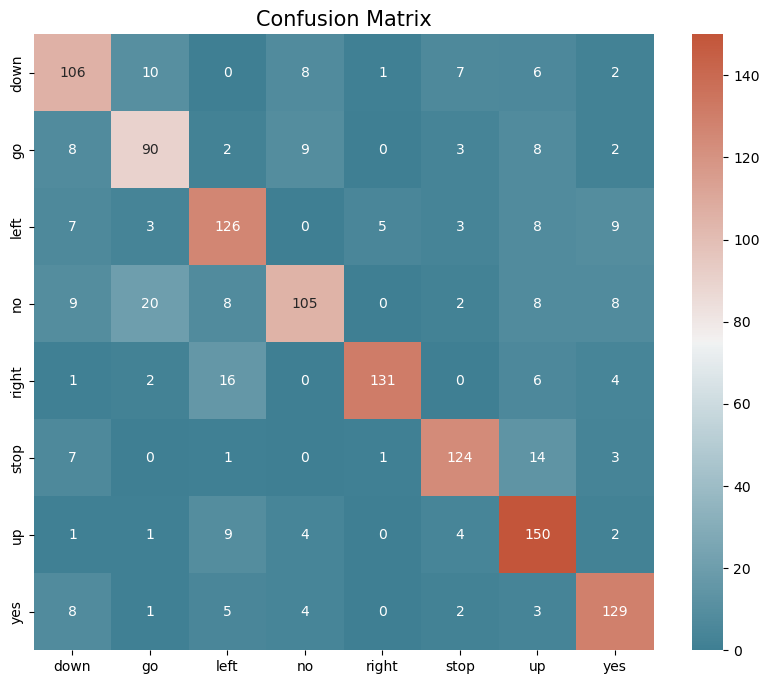

In [130]:
conf_mat = tf.math.confusion_matrix(true_labels, pred_labels)

#cmap = sns.light_palette("seagreen", as_cmap=True)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(conf_mat.numpy(),
                xticklabels = labels,
                yticklabels = labels,
                annot = True,
                cmap = cmap,
                fmt = 'g',
                ax = ax)

ax.set_title('Confusion Matrix', fontsize = 15)

## Real Time Prediction

In [131]:
def process_audio(audio_tensor):
    
    #If tensor shape is less than required sample size
    if audio_tensor.shape[0] < 16000:
        diff = 16000 - audio_tensor.shape[0]
        audio_tensor = tf.concat([audio_tensor, tf.zeros(diff)], axis = 0)

    #Normalizing tensor
    max_val = tf.math.reduce_max(audio_tensor)
    audio_tensor /= max_val

    return(audio_tensor)

In [132]:
def get_prediction(model, correct_label, audio_tensor, use_mfccs = False):

    #Get one hot encoding for correct label
    label_pos = np.argwhere(labels == correct_label)[0][0]
    label_one_hot = encode(label_pos)

    #Get Spectrogram
    spect_rt = get_spectrogram(audio_tensor, label_one_hot, 
                                frame_length = 400, frame_step = 160,
                                filt_noise = False, filt_thresh = 50,
                                add_noise = True, add_noise_thresh = 1e2,                                                   
                                plot = True)
    

    #Get Log mel Spectrogram or MFCCs
    num_mel_bins = 40

    lower_edge_hertz = 20 #Lower limit of human hearing
    upper_edge_hertz = sample_rate // 2 #Nyquist frequency

    num_mfccs = 13
    stack_left, stack_right, stack_padding = 5, 5, False

    log_mel_spect_rt = conv_to_mel(spect_rt,
                                    num_mel_bins,
                                    lower_edge_hertz,
                                    upper_edge_hertz,
                                    get_mfccs = use_mfccs,
                                    num_mfccs = num_mfccs)
    
    if use_mfccs:
        result = mfccs_stack(mfcc_complete(log_mel_spect_rt, N = 2),
                                stack_left, stack_right, stack_padding)
    else:
        result = convolve_spect(log_mel_spect_rt)

    result = result[tf.newaxis]
    pred_rt = model(result)
    pred_rt = tf.nn.softmax(pred_rt)[0].numpy()

    pred_label = labels[np.argmax(pred_rt)]

    #Plot Predictions
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10.5, 5))

    ax.bar(labels, pred_rt)
    ax.set(title = f'Predictions\nCorrect Label: {correct_label}', xlabel = '\nLabel', ylabel = 'Probability\n')

    return(pred_label)   


In [197]:
# Parameters for recording audio
format = pyaudio.paInt16
n_channels = 1
sample_rate = 16000
chunks = 1024
duration = 1

# Initialize PyAudio
audio = pyaudio.PyAudio()

print("Recording...")

# Open stream for recording
stream = audio.open(format=format, channels=n_channels,
                    rate=sample_rate, input=True,
                    frames_per_buffer=chunks)

# Initialize buffer to store audio frames
frames = []

# Record audio for RECORD_SECONDS
for i in range(0, int(sample_rate / chunks * duration)):
    data = stream.read(chunks)
    frames.append(data)

print("Recording finished.")

# Stop and close the stream
stream.stop_stream()
stream.close()
audio.terminate()

# Convert frames to NumPy array
audio_data = np.frombuffer(b''.join(frames), dtype=np.int16)#[:sample_rate]

# Convert audio data to TensorFlow tensor
audio_tensor = tf.convert_to_tensor(audio_data, dtype=tf.float32)

# Example: Print shape of audio tensor
print("Shape of audio tensor:", audio_tensor.shape)


Recording...
Recording finished.
Shape of audio tensor: (15360,)


In [ ]:
audio_tensor = process_audio(audio_tensor)
pred_label = get_prediction(model, correct_label = 'yes', audio_tensor = audio_tensor, use_mfccs = False)
print(f'Predicted Label: {pred_label}\n')